# Project: Food Vision Big

## Check GPU

Google Colab offers free GPUs (thank you Google), however, not all of them are compatiable with mixed precision training.

Google Colab offers:
* K80 (not compatible)
* P100 (not compatible) 
* Tesla T4 (compatible)

Knowing this, in order to use mixed precision training we need access to a Tesla T4 (from within Google Colab) or if we're using our own hardware, our GPU needs a score of 7.0+ (see here: https://developer.nvidia.com/cuda-gpus).

📖 **Resource:** You can read more about the benefits of mixed precision training in the TensorFlow Mixed Precision documentation: https://www.tensorflow.org/guide/mixed_precision 

In [ ]:
import tensorflow as tf
tf.__version__

'2.9.2'

In [ ]:
# If the following line doesn't output "Tesla T4", you can try getting access to
# another GPU by going to Runtime -> Factory Reset Runtime -> "Yes" and then
# re-running this cell.
!nvidia-smi -L

GPU 0: A100-SXM4-40GB (UUID: GPU-05a61ac2-7b6f-9aae-4e2c-a018d5cf1082)


## Get helper functions

In past modules, we've created a bunch of helper functions to do small tasks required for our notebooks.

Rather than rewrite all of these, we can import a script and load them in from there.

The script we've got available can be found on GitHub: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-12-29 18:12:15--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-12-29 18:12:15 (105 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

If you want to get an overview of TensorFlow Datasets (TFDS), read the guide: https://www.tensorflow.org/datasets/overview

In [ ]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [ ]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is our target dataset in the list of TFDS datasets?

True


In [ ]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"], # splits can be a little tricky, for more see: https://www.tensorflow.org/datasets/splits 
                                             shuffle_files=False,  # for predictions metrics
                                             as_supervised=True, # data gets returned in tuple format (data, label)
                                             with_info=True)

## Exploring the Food101 data from TensorFlow Datasets

To become one with our data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names?

In [ ]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [ ]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 16
  Class name (str form): cheesecake
  


In [ ]:
# What does our image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 85,  84,  92],
        [ 86,  85,  93],
        [ 93,  92, 100],
        ...,
        [120, 196, 245],
        [120, 198, 246],
        [121, 199, 247]],

       [[ 88,  88,  96],
        [ 82,  82,  90],
        [ 88,  88,  96],
        ...,
        [116, 192, 244],
        [118, 195, 249],
        [119, 196, 248]],

       [[ 77,  80,  89],
        [ 75,  78,  87],
        [ 82,  86,  95],
        ...,
        [115, 189, 252],
        [117, 192, 255],
        [118, 194, 255]],

       ...,

       [[159, 166, 194],
        [154, 161, 187],
        [171, 178, 204],
        ...,
        [219, 216, 235],
        [223, 220, 239],
        [227, 226, 244]],

       [[170, 179, 208],
        [169, 179, 206],
        [173, 183, 210],
        ...,
        [218, 217, 235],
        [223, 222, 240],
        [226, 227, 245]],

       [[168, 177, 206],
        [170, 179, 208],
        [152, 162, 189],
        ...,
        [224, 223, 24

In [ ]:
# What are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow Datasets

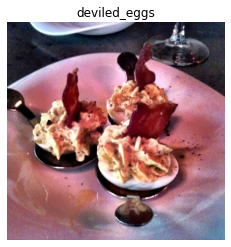

In [ ]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is assosciated with the right image
plt.axis(False);

## Create preprocessing functions for our data

Neural networks perform best when data is in a certain way (e.g. batched, normalized, etc).

However, not all data (including data from from TensorFlow Datasets) comes like this.

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about our data:
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

What we know models like:
* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 & 1) also called normalized tensors generally perform better

With these points in mind, we've got a few things we can tackle with a preprocessing function.

Since we're going to be using an EfficientNetBX pretrained model from tf.keras.applications we don't need to rescale our data (these architectures have rescaling built-in).

This means our functions needs to:
1. Reshape our images to all the same size
2. Convert the dtype of our image tensors from `unit8` to `float32`

In [ ]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes
  image to [img_shape, img_shape, colour_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
  # image = image/255. # scale image values (not required with EfficientNetBX models from tf.keras.applications)
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [ ]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n{preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[ 85  84  92]
  [ 86  85  93]
  [ 93  92 100]
  ...
  [120 196 245]
  [120 198 246]
  [121 199 247]]

 [[ 88  88  96]
  [ 82  82  90]
  [ 88  88  96]
  ...
  [116 192 244]
  [118 195 249]
  [119 196 248]]]..., 
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
[[[ 84.67857   84.321434  92.321434]
  [ 87.19898   86.841835  94.841835]
  [ 84.72959   84.581635  94.72449 ]
  ...
  [119.50503  194.93877  245.85202 ]
  [114.974525 190.97452  241.90309 ]
  [119.071465 196.4286   247.82652 ]]

 [[ 75.647964  84.21939   93.21939 ]
  [ 71.45407   80.959175  89.959175]
  [ 78.03061   87.20408   97.47449 ]
  ...
  [113.31632  182.62755  249.35715 ]
  [106.57655  176.86227  245.4337  ]
  [108.601944 179.9796   248.16833 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


## Batch & prepare datasets

We're now going to make our data input pipeline run really fast. 

For more resources on this, I'd highly going through the following guide: https://www.tensorflow.org/guide/data_performance

In [ ]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks

We're going to create a couple of callbacks to help us while our model trains:
* TensorBoard callback to log training results (so we can visualize them later if need be)
* ModelCheckpoint callback to save our model's progress after feature extraction

In [ ]:
# Create tensorboard callback (import from helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training 
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0) # don't print whether or not model is being saved

## Setup mixed precision training

First and foremost, for a deeper understanding of mixed precision training, check out the TensorFlow guide for mixed precision: https://www.tensorflow.org/guide/mixed_precision

Mixed precision utilizes a combination of float32 and float16 data types to speed up model performance.

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision 

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model

In [ ]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model = tf.keras.applications.ResNet50(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model doesn't you can have a layer like below
# x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # makes sure layers which should be in inference mode only stay like that
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs) 

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 101)               206949    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 23,794,661
Trainable params: 206,949
Non-trainable params: 23,587,712
_________________________________________________________________


## Checking layer dtype policies (are we using mixed precision?)

In [ ]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
resnet50 False float32 <Policy "mixed_float16">
global_average_pooling2d_1 True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:
* `layer.name`: the human readable name of a particular layer
* `layer.trainable`: is the layer trainable or not? (if `False`, the weights are frozen)
* `layer.dtype`: the data type a layer stores its variables in
* `layer.dtype_policy`: the data type policy a layer computes on its variables with

In [ ]:
# Check the dtype_policy attributes of layers in the base model
for layer in model.layers[1].layers[:20]: # check the layers of the base model (layer at index 1 of `model`)
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 False float32 <Policy "float32">
conv1_pad False float32 <Policy "mixed_float16">
conv1_conv False float32 <Policy "mixed_float16">
conv1_bn False float32 <Policy "mixed_float16">
conv1_relu False float32 <Policy "mixed_float16">
pool1_pad False float32 <Policy "mixed_float16">
pool1_pool False float32 <Policy "mixed_float16">
conv2_block1_1_conv False float32 <Policy "mixed_float16">
conv2_block1_1_bn False float32 <Policy "mixed_float16">
conv2_block1_1_relu False float32 <Policy "mixed_float16">
conv2_block1_2_conv False float32 <Policy "mixed_float16">
conv2_block1_2_bn False float32 <Policy "mixed_float16">
conv2_block1_2_relu False float32 <Policy "mixed_float16">
conv2_block1_0_conv False float32 <Policy "mixed_float16">
conv2_block1_3_conv False float32 <Policy "mixed_float16">
conv2_block1_0_bn False float32 <Policy "mixed_float16">
conv2_block1_3_bn False float32 <Policy "mixed_float16">
conv2_block1_add False float32 <Policy "mixed_float16">
conv2_block1_out False fl

In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general order of doing things is:
1. Build a feature extraction model (train a couple output layers with base layers frozen) 
2. Fine-tune some of the frozen layers

In [ ]:
# Fit the feature extraction model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=7,
                                                     steps_per_epoch=(len(train_data)), 
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                            experiment_name="resnet50_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/resnet50_101_classes_all_data_feature_extract/20221229-182813
Epoch 1/7
2368/2368 [==============================] - 66s 28ms/step - loss: 1.3901 - accuracy: 0.6401 - val_loss: 1.8867 - val_accuracy: 0.5567
Epoch 2/7
2368/2368 [==============================] - 66s 28ms/step - loss: 1.3063 - accuracy: 0.6538 - val_loss: 1.8596 - val_accuracy: 0.5575
Epoch 3/7
2368/2368 [==============================] - 66s 28ms/step - loss: 1.2257 - accuracy: 0.6745 - val_loss: 1.8625 - val_accuracy: 0.5707
Epoch 4/7
2368/2368 [==============================] - 66s 28ms/step - loss: 1.1651 - accuracy: 0.6862 - val_loss: 2.0313 - val_accuracy: 0.5490
Epoch 5/7
2368/2368 [==============================] - 66s 27ms/step - loss: 1.1049 - accuracy: 0.6998 - val_loss: 1.9526 - val_accuracy: 0.5683
Epoch 6/7
2368/2368 [==============================] - 66s 28ms/step - loss: 1.0528 - accuracy: 0.7117 - val_loss: 2.0485 - val_accuracy: 0.5556
Epoch 7/7
2368/2368 [

In [ ]:
# Evaluate model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 17s 22ms/step - loss: 2.1130 - accuracy: 0.5460


[2.112982749938965, 0.5459802150726318]

## Save the whole model to file


In [ ]:
# Save model locally
save_dir = "drive/MyDrive/Z2M-DL/MyWalkThrough/07_resnet50_feature_extract_model_mixed_precision/"
model.save(save_dir)

In [ ]:
# Load model previously saved
load_save_model = tf.keras.models.load_model(save_dir)

In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in load_save_model.layers[1].layers[:20]: # check only the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
conv1_pad False float32 <Policy "float32">
conv1_conv False float32 <Policy "float32">
conv1_bn False float32 <Policy "float32">
conv1_relu False float32 <Policy "float32">
pool1_pad False float32 <Policy "float32">
pool1_pool False float32 <Policy "float32">
conv2_block1_1_conv False float32 <Policy "float32">
conv2_block1_1_bn False float32 <Policy "float32">
conv2_block1_1_relu False float32 <Policy "float32">
conv2_block1_2_conv False float32 <Policy "float32">
conv2_block1_2_bn False float32 <Policy "float32">
conv2_block1_2_relu False float32 <Policy "float32">
conv2_block1_0_conv False float32 <Policy "float32">
conv2_block1_3_conv False float32 <Policy "float32">
conv2_block1_0_bn False float32 <Policy "float32">
conv2_block1_3_bn False float32 <Policy "float32">
conv2_block1_add False float32 <Policy "float32">
conv2_block1_out False float32 <Policy "float32">
conv2_block2_1_conv False float32 <Policy "float32">


In [ ]:
# Check the loaded model performance
results_load_save_model = load_save_model.evaluate(test_data)
results_load_save_model

790/790 [==============================] - 19s 23ms/step - loss: 2.1130 - accuracy: 0.5460


[2.1129820346832275, 0.5459802150726318]

In [ ]:
# The loaded model's results should equal (or at least be very close) to the model's results prior to saving
# Note: this will only work if you've instatiated results variables 
import numpy as np
assert np.isclose(results_feature_extract_model, results_load_save_model).all()

## Preparing our model's layers for fine-tuning

Fine-tune the feature extraction model to beat the DeepFood paper.

In [ ]:
# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip 

--2022-12-29 18:40:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  9.33MB/s    in 1.7s    

2022-12-29 18:40:46 (9.33 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [ ]:
# Unzip the SavedModel downloaded from Google Stroage
!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [ ]:
# Load and evaluate downloaded GS model
loaded_gs_model = tf.keras.models.load_model("downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

In [ ]:
# Get a summary of the downloaded model
loaded_gs_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# How does the loaded model perform? (evaluate it on the test dataset)
results_loaded_gs_model = loaded_gs_model.evaluate(test_data)
results_loaded_gs_model

790/790 [==============================] - 15s 16ms/step - loss: 1.0881 - accuracy: 0.7064


[1.088110089302063, 0.7064158320426941]

In [ ]:
# Set all of the layers .trainable variable in the loaded model to True (so they're unfrozen)
for layer in loaded_gs_model.layers:
  layer.trainable = True # set all layers to trainable
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_gs_model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
# Monitor the val_loss and stop training if it doesn't improve for 3 epochs
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping for more
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
# Save the best model only
# Monitor val_loss while training and save the best model (lowest val_loss)
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint for more
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [ ]:
# Compile the model ready for fine-tuning
loaded_gs_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [ ]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = loaded_gs_model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20221229-184249
Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 0.9228 - accuracy: 0.7529

2368/2368 [==============================] - 196s 77ms/step - loss: 0.9228 - accuracy: 0.7529 - val_loss: 0.8175 - val_accuracy: 0.7720 - lr: 1.0000e-04
Epoch 2/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.5768 - accuracy: 0.8403

2368/2368 [==============================] - 181s 76ms/step - loss: 0.5768 - accuracy: 0.8404 - val_loss: 0.7884 - val_accuracy: 0.7868 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 143s 60ms/step - loss: 0.3289 - accuracy: 0.9057 - val_loss: 0.8501 - val_accuracy: 0.7805 - lr: 1.0000e-04
Epoch 4/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.1707 - accuracy: 0.9501
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 143s 60ms/step - loss: 0.1707 - accuracy: 0.9501 - val_loss: 1.0163 - val_accuracy: 0.7786 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 142s 60ms/step - loss: 0.0351 - accuracy: 0.9921 - val_loss: 1.0626 - val_accuracy: 0.7982 - lr: 2.0000e-05


In [ ]:
# Evaluate mixed precision trained fine-tuned model (this should beat DeepFood's 77.4% top-1 accuracy)
results_downloaded_fine_tuned_gs_model = loaded_gs_model.evaluate(test_data)
results_downloaded_fine_tuned_gs_model

790/790 [==============================] - 15s 19ms/step - loss: 1.0687 - accuracy: 0.7941


[1.0687203407287598, 0.7940593957901001]

## View training results on TensorBoard

Upload and view your model's training results to TensorBoard.dev and view them.

In [ ]:
# Upload experiment results to TensorBoard (uncomment to run)
!tensorboard dev upload --logdir ./training_logs \
   --name "Fine-tuning EfficientNetB0 on all Food101 Data" \
   --description "Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001" \
   --one_shot

In [ ]:
# View past TensorBoard experiments
!tensorboard dev list

https://tensorboard.dev/experiment/mfEeLhVOSpu5rD1ZbcMT3w/
	Name                 Fine-tuning EfficientNetB0 on all Food101 Data
	Description          Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001
	Id                   mfEeLhVOSpu5rD1ZbcMT3w
	Created              2022-12-29 18:58:35 (2 minutes ago)
	Updated              2022-12-29 18:58:43 (1 minute ago)
	Runs                 8
	Tags                 5
	Scalars              90
	Tensor bytes         0
	Binary object bytes  2963686
Total: 1 experiment(s)


In [ ]:
# Delete past TensorBoard experiments
!tensorboard dev delete --experiment_id YOUR_EXPERIMENT_ID

# Example
!tensorboard dev delete --experiment_id mfEeLhVOSpu5rD1ZbcMT3w

## Evaluate your trained model
Some ideas you might want to go through:

Find the precision, recall and f1 scores for each class (all 101).
Build a confusion matrix for each of the classes.
Find your model's most wrong predictions (those with the highest prediction probability but the wrong prediction).

In [ ]:
from helper_functions import make_confusion_matrix

In [ ]:
# Make Predictions
y_preds = loaded_gs_model.predict(test_data, verbose=1)

790/790 [==============================] - 13s 16ms/step


In [ ]:
len(y_preds), y_preds.shape

(25250, (25250, 101))

In [ ]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(y_preds[0])}")
print(f"What prediction probability sample 0 looks like:\n {y_preds[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {y_preds[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [9.9445417e-05 6.8657109e-14 4.1169785e-12 3.2754477e-13 1.2788280e-07
 1.1432436e-12 3.2431323e-14 2.9316760e-10 3.9166393e-06 6.7775399e-09
 5.7313093e-07 1.9065394e-14 4.1755213e-09 3.3170272e-07 1.8606836e-07
 4.1642647e-14 7.8667807e-05 8.2915249e-06 1.1097389e-15 1.2342817e-09
 5.0306289e-17 8.4703260e-07 4.0010985e-07 2.3791404e-09 1.7706904e-12
 3.6694228e-11 1.5939246e-10 1.7208511e-07 6.3669092e-09 9.9894267e-01
 2.4509700e-06 6.8060984e-07 5.5801175e-16 5.8902601e-20 6.9821635e-06
 5.7572496e-16 3.5661405e-06 3.7115685e-13 2.9868216e-16 1.8848898e-12
 2.3963687e-13 1.2309543e-14 7.2038019e-06 1.3539754e-17 6.7877500e-12
 5.3534113e-06 4.1642647e-14 1.9896522e-16 5.7728121e-11 3.3360219e-08
 1.1367341e-11 1.4087525e-13 3.3460807e-14 1.6420476e-07 1.8905732e-18
 9.9745261e-11 1.0016555e-08 3.4130951e-12 1.0921942e-04 4.8132353e-12
 9.5866808e-15 2.5470845e-10 7.0836518e-14 6.

In [ ]:
# Get the class predicitons of each label
pred_classes = y_preds.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 29,  81,  91,  53,  97,  97,  10,  31,   3, 100])

In [ ]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy())
y_labels[:10]

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [ ]:
len(y_labels)

25250

In [ ]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy
     

0.7940594059405941

In [ ]:
# Get the class names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

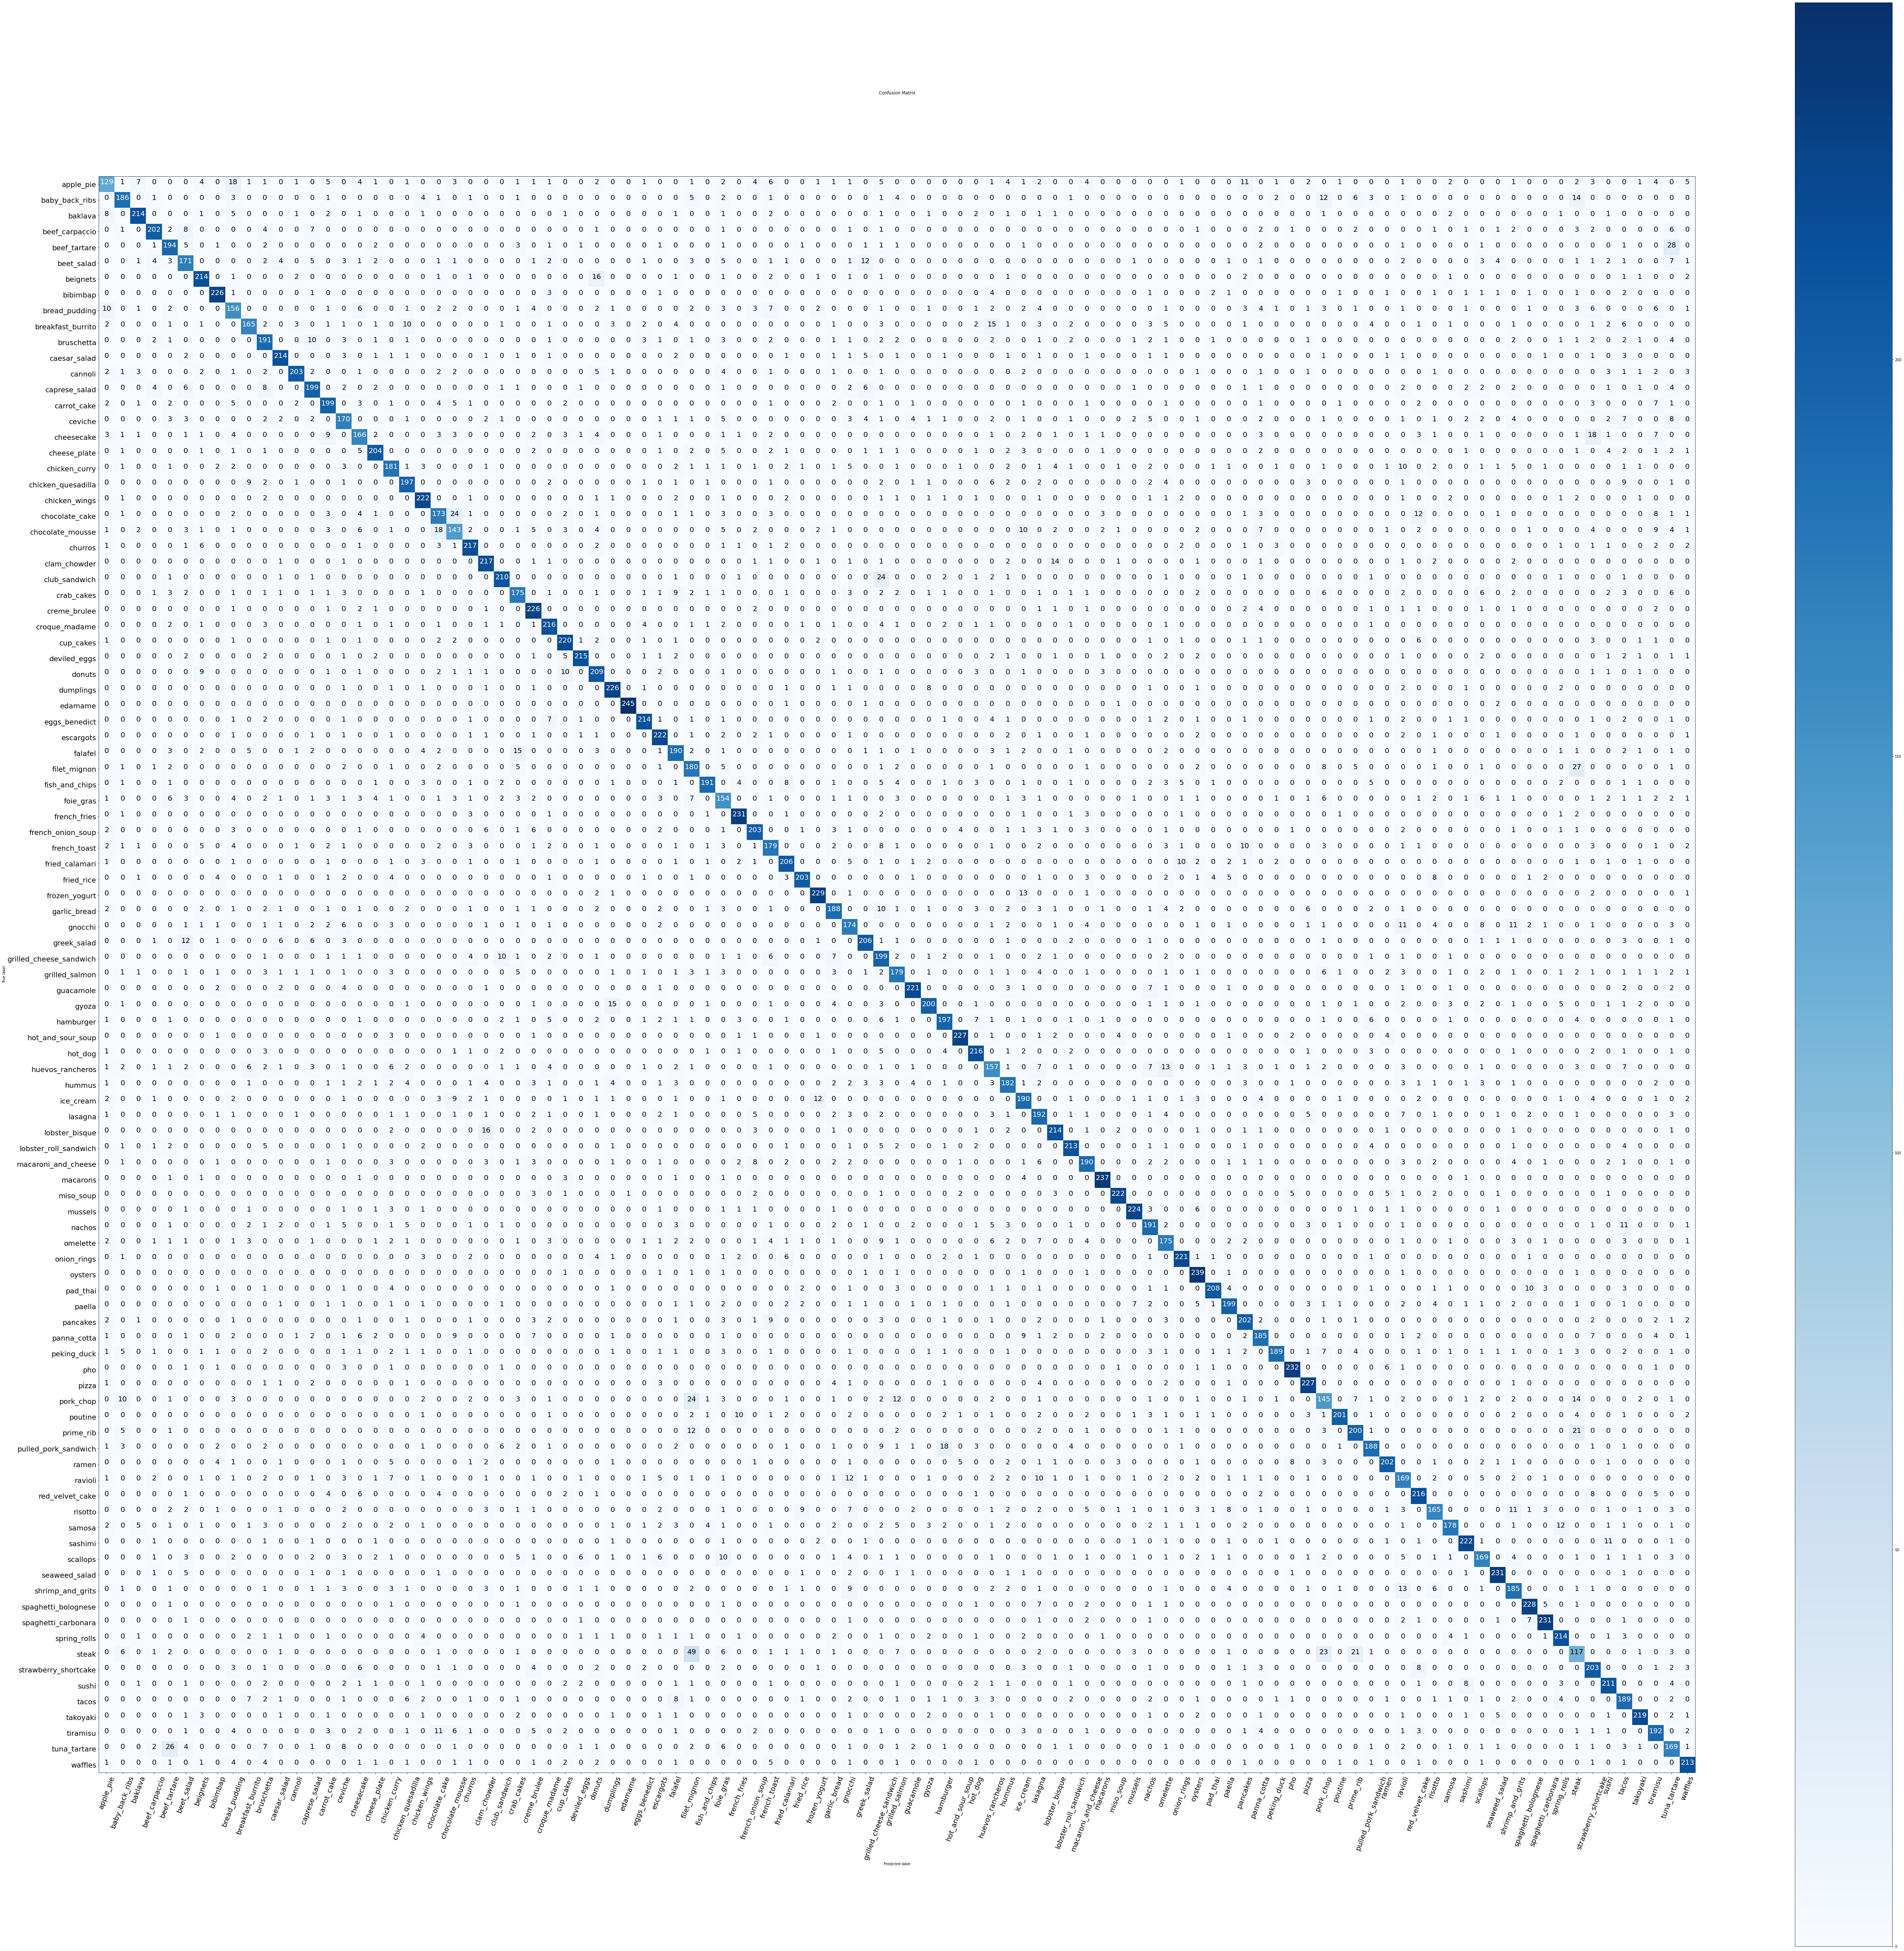

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=False)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.69      0.52      0.59       250
           1       0.79      0.74      0.77       250
           2       0.89      0.86      0.87       250
           3       0.88      0.81      0.84       250
           4       0.72      0.78      0.75       250
           5       0.70      0.68      0.69       250
           6       0.83      0.86      0.84       250
           7       0.90      0.90      0.90       250
           8       0.64      0.62      0.63       250
           9       0.81      0.66      0.73       250
          10       0.69      0.76      0.72       250
          11       0.87      0.86      0.86       250
          12       0.93      0.81      0.87       250
          13       0.78      0.80      0.79       250
          14       0.79      0.80      0.79       250
          15       0.66      0.68      0.67       250
          16       0.70      0.66      0.68       250
          17       0.86    

In [ ]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.6935483870967742,
  'recall': 0.516,
  'f1-score': 0.591743119266055,
  'support': 250},
 '1': {'precision': 0.7914893617021277,
  'recall': 0.744,
  'f1-score': 0.7670103092783506,
  'support': 250},
 '2': {'precision': 0.8879668049792531,
  'recall': 0.856,
  'f1-score': 0.8716904276985744,
  'support': 250},
 '3': {'precision': 0.8782608695652174,
  'recall': 0.808,
  'f1-score': 0.8416666666666667,
  'support': 250},
 '4': {'precision': 0.7185185185185186,
  'recall': 0.776,
  'f1-score': 0.7461538461538462,
  'support': 250},
 '5': {'precision': 0.6951219512195121,
  'recall': 0.684,
  'f1-score': 0.6895161290322581,
  'support': 250},
 '6': {'precision': 0.8262548262548263,
  'recall': 0.856,
  'f1-score': 0.8408644400785855,
  'support': 250},
 '7': {'precision': 0.900398406374502,
  'recall': 0.904,
  'f1-score': 0.9021956087824352,
  'support': 250},
 '8': {'precision': 0.6419753086419753,
  'recall': 0.624,
  'f1-score': 0.6328600405679513,
  'support': 

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.591743119266055,
 'baby_back_ribs': 0.7670103092783506,
 'baklava': 0.8716904276985744,
 'beef_carpaccio': 0.8416666666666667,
 'beef_tartare': 0.7461538461538462,
 'beet_salad': 0.6895161290322581,
 'beignets': 0.8408644400785855,
 'bibimbap': 0.9021956087824352,
 'bread_pudding': 0.6328600405679513,
 'breakfast_burrito': 0.7284768211920529,
 'bruschetta': 0.7248576850094877,
 'caesar_salad': 0.8611670020120724,
 'cannoli': 0.8675213675213674,
 'caprese_salad': 0.7865612648221344,
 'carrot_cake': 0.7912524850894632,
 'ceviche': 0.6692913385826772,
 'cheesecake': 0.6817248459958932,
 'cheese_plate': 0.8395061728395061,
 'chicken_curry': 0.724,
 'chicken_quesadilla': 0.8024439918533605,
 'chicken_wings': 0.8638132295719845,
 'chocolate_cake': 0.7046843177189409,
 'chocolate_mousse': 0.6098081023454158,
 'churros': 0.857707509881423,
 'clam_chowder': 0.8378378378378377,
 'club_sandwich': 0.853658536585366,
 'crab_cakes': 0.7172131147540984,
 'creme_brulee': 0.830882352941

In [ ]:
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1_scores": list(class_f1_scores.values())}).sort_values("f1_scores", ascending=False)
f1_scores

,class_names,f1_scores
33,edamame,0.987903
63,macarons,0.940476
54,hot_and_sour_soup,0.924644
75,pho,0.922465
91,spaghetti_carbonara,0.922156
...,...,...
22,chocolate_mousse,0.609808
39,foie_gras,0.592308
77,pork_chop,0.591837
0,apple_pie,0.591743


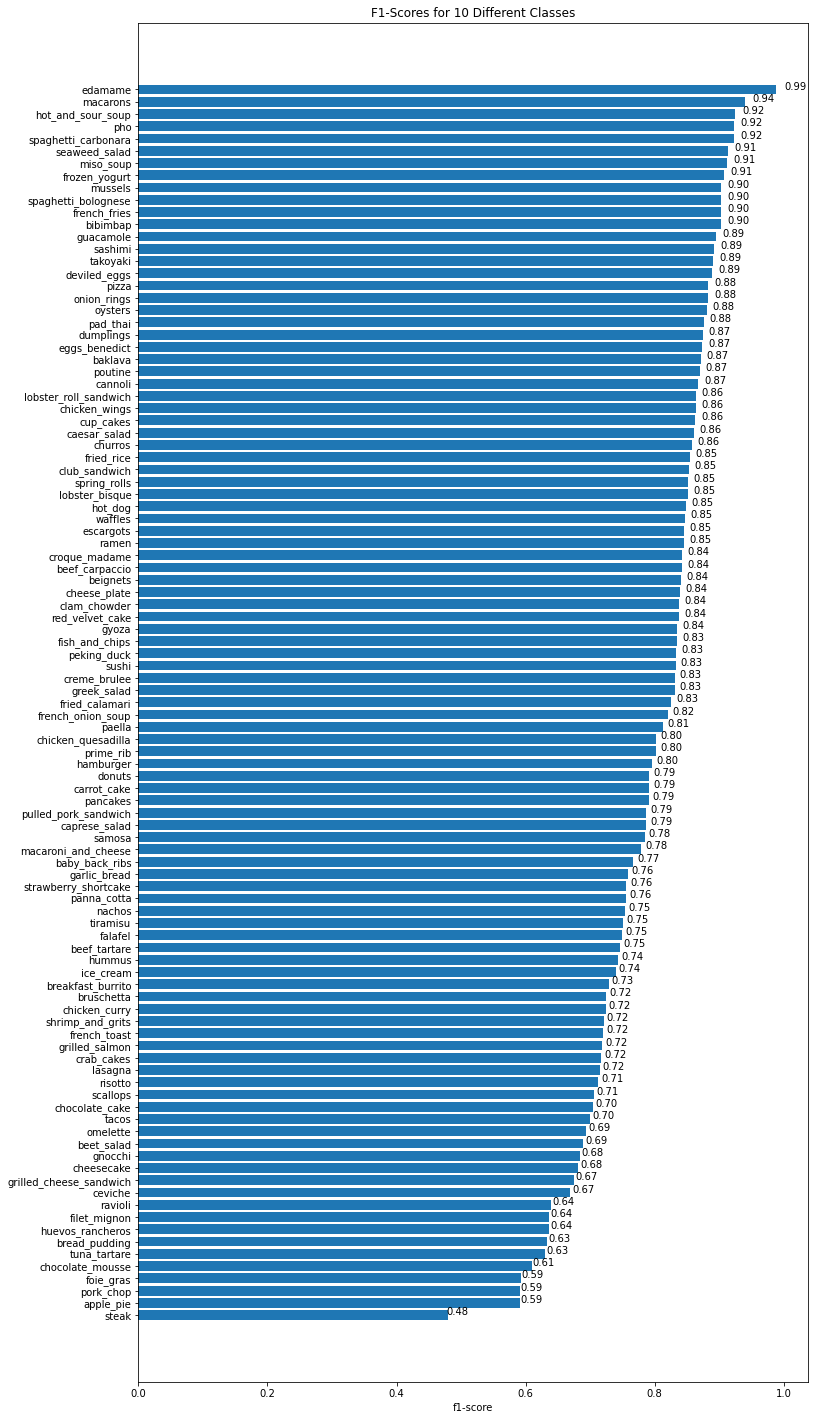

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1_scores"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_names"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

### Finding Most Wrong Predictions

In [ ]:
import pandas
pred_df = pd.DataFrame({
    "y_true": y_labels,
    "y_pred": pred_classes,
    "pred_conf": y_preds.max(axis=1),
    "y_true_classname": [class_names[i] for i in y_labels],
    "y_pred_classname": [class_names[i] for i in pred_classes]
})

pred_df.head()

,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,29,29,0.998943,cup_cakes,cup_cakes
1,81,81,0.999853,ramen,ramen
2,91,91,0.999978,spaghetti_carbonara,spaghetti_carbonara
3,53,53,0.989593,hamburger,hamburger
4,97,97,0.999978,takoyaki,takoyaki


In [ ]:
# Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()
     

,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,29,29,0.998943,cup_cakes,cup_cakes,True
1,81,81,0.999853,ramen,ramen,True
2,91,91,0.999978,spaghetti_carbonara,spaghetti_carbonara,True
3,53,53,0.989593,hamburger,hamburger,True
4,97,97,0.999978,takoyaki,takoyaki,True


In [ ]:
# Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
15437,56,66,1.000000,huevos_rancheros,nachos,False
15071,85,92,1.000000,samosa,spring_rolls,False
900,14,29,1.000000,carrot_cake,cup_cakes,False
16129,65,69,1.000000,mussels,oysters,False
13884,46,10,1.000000,garlic_bread,bruschetta,False
9735,87,30,1.000000,scallops,deviled_eggs,False
1420,93,79,1.000000,steak,prime_rib,False
1113,72,67,0.999999,pancakes,omelette,False
7853,71,87,0.999999,paella,scallops,False
2379,31,6,0.999999,donuts,beignets,False
